In [44]:
import os
import torch
import pandas as pd
from PIL import Image
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from random import random, randrange
from torchvision import transforms,models
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [15]:
!unzip '/content/drive/My Drive/challenge/data.zip' -d '/content'

Archive:  /content/drive/My Drive/challenge/data.zip
   creating: /content/data/
   creating: /content/data/DAM/
  inflating: /content/data/DAM/010M03A1116X9000.jpeg  
  inflating: /content/data/DAM/010M09A1101X0863.jpeg  
  inflating: /content/data/DAM/010M27A0006X0200.jpeg  
  inflating: /content/data/DAM/011A11A1166X4150.jpeg  
  inflating: /content/data/DAM/011A11A1166X9000.jpeg  
  inflating: /content/data/DAM/011B13A6014X0200.jpeg  
  inflating: /content/data/DAM/011B48A3874X0863.jpeg  
  inflating: /content/data/DAM/011D01A1166X5645.jpeg  
  inflating: /content/data/DAM/011D01A1166X9000.jpeg  
  inflating: /content/data/DAM/011D02A1166X3250.jpeg  
  inflating: /content/data/DAM/011G05ACMIXX0863.jpeg  
  inflating: /content/data/DAM/011G07A1166X9000.jpeg  
  inflating: /content/data/DAM/011G12A1166X4150.jpeg  
  inflating: /content/data/DAM/011G13A1212X0200.jpeg  
  inflating: /content/data/DAM/011J12A1166X9000.jpeg  
  inflating: /content/data/DAM/011J22X8801X9000.jpeg  
  infla

In [46]:
os.chdir('/content')
PRODUCTS_CSV_PATH = os.path.join("data","product_list.csv")
CLEAN_IMAGES_CSV_PATH = os.path.join("data","DAM")
TEST_IMAGES_PATH = os.path.join("data","test_image_headmind")

In [47]:
products_df = pd.read_csv(PRODUCTS_CSV_PATH)
products_df.columns = ["MMC","ProdBU"]
products_df.head()

products = {
    "MMC": products_df["MMC"].to_list(),
    "ProdBU": products_df["ProdBU"].to_list()
}
products

{'MMC': ['010M03A1116X9000',
  '010M09A1101X0863',
  '010M27A0006X0200',
  '011A11A1166X4150',
  '011A11A1166X9000',
  '011B13A6014X0200',
  '011B48A3874X0863',
  '011D01A1166X5645',
  '011D01A1166X9000',
  '011D02A1166X3250',
  '011G05ACMIXX0863',
  '011G07A1166X9000',
  '011G12A1166X4150',
  '011G13A1212X0200',
  '011J12A1166X9000',
  '011J22X8801X9000',
  '011J50A8976X9632',
  '011P11A1166X9000',
  '011P12A3862X0863',
  '011P34A1166X5435',
  '011R33A7970X9639',
  '011R68A1212X4150',
  '011R70A1166X9000',
  '011V41A3062X5435',
  '012A09A3232X5597',
  '012B03A3985X5902',
  '012J03A3236X0835',
  '013L02A4006X5435',
  '013T03WC437X9663',
  '013T05TU430X0854',
  '014C10AM034X1705',
  '014E01CM514X0863',
  '014E20CM514X0863',
  '014E20TU507X0850',
  '014P02AM042X5800',
  '014S26AM028X2847',
  '014S52AM044X9650',
  '014S52WC029X0863',
  '014S55AM042X0820',
  '014S58AM304X0200',
  '014S59AM005X4220',
  '014S62TM033X5902',
  '014S73AM105X4235',
  '014S92AM032X0863',
  '015R30AL030X9000',
  '

In [48]:
training_images = {}
training_list = []

for mmc in products["MMC"]:
    training_list.append(os.path.join(CLEAN_IMAGES_CSV_PATH,f'{mmc}.jpeg'))
    training_images[mmc] = os.path.join(CLEAN_IMAGES_CSV_PATH,f'{mmc}.jpeg')

In [49]:
img_test = training_list[0]
pil_image = Image.open(img_test)
transform = transforms.ToTensor()
img_test = transform(pil_image)
torch.min(img_test)

tensor(0.)

In [50]:
CLEAN_IMAGES_CSV_PATH = os.path.join("data","DAM")
reference_images = [os.path.join(CLEAN_IMAGES_CSV_PATH, img)for img in os.listdir(CLEAN_IMAGES_CSV_PATH)]

TEST_IMAGES_PATH = os.path.join("data","test_image_headmind")
img_list = [os.path.join(TEST_IMAGES_PATH,i) for i in os.listdir(TEST_IMAGES_PATH)]

## Dataset creation

In [51]:
class TrainingDataset(Dataset):
    def __init__(self, img_list,transform=None):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        self.img_list = img_list
        self.transform_query = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
            transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.5),
            transforms.RandomResizedCrop(256,(0.5,1))
        ])

        self.transform_target = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

        self.data_len = len(self.img_list)


    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_path = self.img_list[idx]
        image1 = Image.open(img_path)
        image1 = self.transform_query(image1)
        mask = (image1 == 0).all(dim=0)
        image1[:,mask] = 1.
        same_idx = torch.tensor(1.)

        if randrange(2):
            idx2 = randrange(self.data_len)
            img_path = self.img_list[idx2]
            if idx != idx2:
                same_idx = torch.tensor(-1.)

        image2 = Image.open(img_path)
        image2 = self.transform_target(image2)

        return (image1, image2), same_idx

In [52]:
class TestImgDataset(Dataset):
    def __init__(self,img_list,transform=None):
        self.img_list = img_list
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std)
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self,idx):
        img_path = self.img_list[idx]
        img = Image.open(img_path)
        return self.transform(img)

## Creating dataloaders

In [53]:
imgs = os.listdir(TEST_IMAGES_PATH)
img_list = [os.path.join(TEST_IMAGES_PATH,i) for i in imgs]
img_dataset = TrainingDataset(training_list)
compar_dataset = TestImgDataset(training_list)
client_dataset = TestImgDataset(img_list)
train_dataloader = DataLoader(img_dataset,batch_size=32,shuffle=True)
test_dataloader = DataLoader(compar_dataset, batch_size=32, shuffle=False)
client_dataloader = DataLoader(client_dataset,batch_size=32, shuffle=False)

## Showing results of data augmentation

tensor(1.)


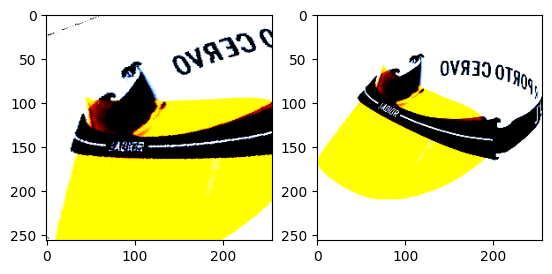

In [54]:
(img1, img2), same_idx = next(iter(train_dataloader))
fix, axs = plt.subplots(ncols=2, squeeze=False)
axs[0,0].imshow(img1[0].permute(1,2,0))
axs[0,1].imshow(img2[0].permute(1,2,0))
print(same_idx[0])

## Importing resnet50 model

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [56]:
model = models.resnet50(weights="IMAGENET1K_V2")
model.to(device);

## Removing Classifier layer

In [57]:
model.fc = nn.Identity()

In [58]:
csv_all = pd.read_csv("results17-32.csv",header=None, sep=", ")
csv_arthur = pd.read_csv("answer65-80.csv", header=None, sep=", ")
csv_all = pd.concat([pd.read_csv("answers1-16.csv", header=None, sep= ", "),csv_all, pd.read_csv("results33-48.csv", header=None, sep=", "), pd.read_csv("results49-64.csv", header=None, sep=", "), csv_arthur])
csv_all.head()
csv_all.columns = ['0','1']

answers = {}
for _, row in csv_all.iterrows():
    if row['1'] in answers.keys():
        answers[row['1']].append(row['0'])
    else:
        answers[row['1']] = [row['0']]

<ipython-input-58-69066da95cd9>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_all = pd.read_csv("results17-32.csv",header=None, sep=", ")
<ipython-input-58-69066da95cd9>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_arthur = pd.read_csv("answer65-80.csv", header=None, sep=", ")
<ipython-input-58-69066da95cd9>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  csv_all = pd.concat([pd.read_csv("answers

## Contrastive training of the ResNet

In [70]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CosineEmbeddingLoss(margin=0.3)

for epoch in range(20):
    print(f"EPOCH {epoch}")
    current_loss = 0.0
    for i, data in enumerate(train_dataloader):
        (img1, img2), same_img = data
        img1, img2, same_img = img1.to(device), img2.to(device), same_img.to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1), model(img2)
        loss = criterion(output1,output2,same_img)
        current_loss += loss.item()
        loss.backward()
        optimizer.step()
        if i%20 == 0 and i > 0:
            print(f"{i} loss train: {current_loss}")
            current_loss = 0.0

    test_model(model,test_dataloader,client_dataloader)

EPOCH 0
20 loss train: 1.9705827441066504
40 loss train: 1.9774199463427067
60 loss train: 1.799174465239048
80 loss train: 1.7394929267466068


100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Top 10 precision on the test set: 1.2987012987012987% 

EPOCH 1
20 loss train: 1.8294723890721798
40 loss train: 2.18421184271574


KeyboardInterrupt: 

In [67]:
def test_model(model, test_dataloader, client_dataloader):
  reference_features = []
  client_features = []
  with torch.no_grad():
    model.eval()
    for data in tqdm(test_dataloader):
      reference_features.append(model(data.to(device)))

    for data in tqdm(client_dataloader):
      client_features.append(model(data.to(device)))

    model.train()

  reference_features = torch.cat(reference_features).cpu()
  client_features = torch.cat(client_features).cpu()
  client_embedding_tensor = client_features
  embedding_tensor = reference_features
  client_embedding_tensor_normalized = client_embedding_tensor / client_embedding_tensor.norm(dim=1, keepdim=True)
  embedding_tensor_normalized = embedding_tensor / embedding_tensor.norm(dim=1, keepdim=True)

  cosine_similarities = torch.mm(client_embedding_tensor_normalized, embedding_tensor_normalized.t())

  closest_indices = torch.argsort(cosine_similarities, dim=1,descending=True)[:,:10]

  guesses = {}

  for i, img in enumerate(img_list):
      file_name = img.split("/")[-1]
      img_id = file_name.split(".")[0]
      guesses[img_id] = [reference_images[ind] for ind in closest_indices[i].tolist()]

  accuracy = 0
  nb_guess = 0
  for answer_key in answers.keys():
      found = 0
      if answer_key in guesses.keys():
          nb_guess += 1
          for value_guess in guesses[answer_key]:
              for value_answ in answers[answer_key]:
                  if value_answ in value_guess and not found:
                      accuracy += 1
                      found = 1
  accu = accuracy/nb_guess*100
  print(f"Top 10 precision on the test set: {accu}% \n")


In [61]:
img_list[0]

'data/test_image_headmind/MicrosoftTeams-image_45.png'

In [34]:
client_embedding_tensor = client_features
embedding_tensor = reference_features
client_embedding_tensor_normalized = client_embedding_tensor / client_embedding_tensor.norm(dim=1, keepdim=True)
embedding_tensor_normalized = embedding_tensor / embedding_tensor.norm(dim=1, keepdim=True)

cosine_similarities = torch.mm(client_embedding_tensor_normalized, embedding_tensor_normalized.t())

closest_indices = torch.argsort(cosine_similarities, dim=1,descending=True)[:,:10]
closest_indices

tensor([[2542, 2541, 2638, 2345, 2534, 2742, 2501, 2634, 2346, 2736],
        [1811, 2046, 1794, 1715, 2036, 1834, 1850, 1844, 1847, 1817],
        [2353, 2347, 2348, 2352, 2351, 2633, 2503, 2537, 2538,  961],
        [2095, 2184, 2141, 2131, 2166, 2185, 2192, 2162, 2176, 2164],
        [2350, 2541, 2542, 2543, 2526, 2345, 2642, 2638, 2632, 2346],
        [1724,  934, 1731, 1089, 1190, 1201, 1212, 1732, 1203,  743],
        [2737, 2523, 2742, 2534, 2530, 2765, 2741, 2524, 2532, 2685],
        [2353, 2347, 2537, 2351, 2348, 2538, 2633, 2352, 2512, 2503],
        [2528, 2345, 2632, 2629, 2541, 2522, 2350, 2526, 2512, 2642],
        [2511, 2352, 2351, 2538, 2501, 2742, 2737, 2530, 2527, 2434],
        [ 877, 1717,  794, 1709,  725,  907,  815,  899,  774,  814],
        [1806, 2044, 2032, 1996, 1820, 2029, 1941, 2027, 2033, 2041],
        [1249, 1250, 1332,  875, 1193, 1356,  929, 1336, 1260, 1392],
        [2166, 2162, 2141, 2159, 2160, 2163, 2184, 1650, 2167, 2185],
        [2528, 2345,

In [41]:
img_list[0]

'data/test_image_headmind/MicrosoftTeams-image_45.png'